In [1]:
# 1. Import thư viện và thiết lập môi trường
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score, roc_auc_score, accuracy_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import models
import timm
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import albumentations as A
from albumentations.pytorch import ToTensorV2

# Seed để tái tạo kết quả
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything()

# Kiểm tra GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Sử dụng device: {device}')

# 2. Đường dẫn dữ liệu - Sử dụng dữ liệu đã phân chia sẵn
# Đường dẫn chính (điều chỉnh theo môi trường của bạn)
SPLIT_DIR = '/kaggle/input/isic-stest'

# Đường dẫn train
TRAIN_IMG_DIR = os.path.join(SPLIT_DIR, 'train/images')
TRAIN_SEG_DIR = os.path.join(SPLIT_DIR, 'train/segmentations')
TRAIN_LABELS_PATH = os.path.join(SPLIT_DIR, 'train_labels.csv')
TRAIN_METADATA_PATH = os.path.join(SPLIT_DIR, 'train_metadata.csv')

# Đường dẫn validation
TEST_IMG_DIR = os.path.join(SPLIT_DIR, 'valid/images')
TEST_SEG_DIR = os.path.join(SPLIT_DIR, 'valid/segmentations')
TEST_LABELS_PATH = os.path.join(SPLIT_DIR, 'valid_labels.csv')
TEST_METADATA_PATH = os.path.join(SPLIT_DIR, 'valid_metadata.csv')

# Đường dẫn test
VAL_IMG_DIR = os.path.join(SPLIT_DIR, 'test/images')
VAL_SEG_DIR = os.path.join(SPLIT_DIR, 'test/segmentations')
VAL_LABELS_PATH = os.path.join(SPLIT_DIR, 'test_labels.csv')
VAL_METADATA_PATH = os.path.join(SPLIT_DIR, 'test_metadata.csv')

# Khởi tạo thư mục để lưu checkpoint và kết quả
os.makedirs('checkpoints', exist_ok=True)
os.makedirs('results', exist_ok=True)

# 3. Hàm chuyển đổi từ one-hot labels sang single label (đa lớp)
def convert_to_multiclass(df):
    """Chuyển đổi từ dạng one-hot (nhiều cột nhãn) sang nhãn dạng số"""
    # Tìm các cột nhãn (loại bỏ 'image', 'diagnosis', 'label' nếu có)
    label_columns = [col for col in df.columns if col not in ['image', 'diagnosis', 'label']]
    
    # Tạo bản sao để tránh thay đổi df gốc
    result_df = df.copy()
    
    # Tạo cột 'diagnosis' chứa tên của lớp có giá trị 1.0
    result_df['diagnosis'] = result_df[label_columns].idxmax(axis=1)
    
    # Tạo ánh xạ từ tên lớp sang số
    class_names = sorted(label_columns)
    label_map = {class_name: i for i, class_name in enumerate(class_names)}
    
    # Tạo cột 'label' chứa chỉ số số nguyên của lớp
    result_df['label'] = result_df['diagnosis'].map(label_map)
    
    return result_df, label_map, class_names

# 4. Xử lý dữ liệu metadata
def process_metadata(metadata_df):
    """Xử lý metadata để đảm bảo không có giá trị thiếu và các kiểu dữ liệu phù hợp"""
    # Lọc cột cần dùng
    metadata_df = metadata_df[['image', 'age_approx', 'anatom_site_general', 'sex']].copy()
    
    # Xử lý cột age_approx
    metadata_df['age_approx'] = pd.to_numeric(metadata_df['age_approx'], errors='coerce')
    age_mean = metadata_df['age_approx'].mean()
    metadata_df['age_approx'] = metadata_df['age_approx'].fillna(age_mean)
    
    # Chuẩn hóa age_approx về khoảng [0, 1]
    age_min = metadata_df['age_approx'].min()
    age_max = metadata_df['age_approx'].max()
    metadata_df['age_approx'] = (metadata_df['age_approx'] - age_min) / (age_max - age_min)
    
    # Xử lý cột anatom_site_general
    metadata_df['anatom_site_general'] = metadata_df['anatom_site_general'].fillna('unknown')
    site_dummies = pd.get_dummies(metadata_df['anatom_site_general'], prefix='site')
    
    # Xử lý cột sex
    metadata_df['sex'] = metadata_df['sex'].fillna('unknown')
    sex_dummies = pd.get_dummies(metadata_df['sex'], prefix='sex')
    
    # Kết hợp các cột
    metadata_processed = pd.concat([
        metadata_df[['image']],
        metadata_df[['age_approx']],
        site_dummies,
        sex_dummies
    ], axis=1)
    
    # Đảm bảo không có giá trị NaN
    metadata_processed = metadata_processed.fillna(0)
    
    # Xác định các cột đặc trưng
    meta_feature_cols = metadata_processed.columns.tolist()[1:]
    
    return metadata_processed, meta_feature_cols

# 5. Định nghĩa transformations cho augmentation
def get_train_transforms(use_seg=True):
    height, width = 224, 224
    n_channels = 3 + (1 if use_seg else 0)
    
    return A.Compose([
        A.RandomRotate90(),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=15),
        A.RandomBrightnessContrast(),
        A.Resize(height=height, width=width),
        A.Normalize(mean=[0.485, 0.456, 0.406] + [0.5] * (n_channels - 3),
                   std=[0.229, 0.224, 0.225] + [0.5] * (n_channels - 3)),
        ToTensorV2(),
    ])

def get_valid_transforms(use_seg=True):
    height, width = 224, 224
    n_channels = 3 + (1 if use_seg else 0)
    
    return A.Compose([
        A.Resize(height=height, width=width),
        A.Normalize(mean=[0.485, 0.456, 0.406] + [0.5] * (n_channels - 3),
                   std=[0.229, 0.224, 0.225] + [0.5] * (n_channels - 3)),
        ToTensorV2(),
    ])

# 6. Dataset class cho phân loại đa lớp
class DermDataset(Dataset):
    def __init__(self, img_dir, df, metadata_df=None, meta_cols=None, seg_dir=None, 
                 transform=None, use_seg=True, use_meta=False):
        self.img_dir = img_dir
        self.df = df
        self.metadata_df = metadata_df
        self.meta_cols = meta_cols
        self.seg_dir = seg_dir
        self.transform = transform
        self.use_seg = use_seg
        self.use_meta = use_meta
        
        self.image_names = df['image'].values
        # Thay đổi: sử dụng nhãn dạng số thay vì one-hot
        self.labels = df['label'].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        
        # Đọc ảnh
        img_path = os.path.join(self.img_dir, img_name + '.jpg')
        img = cv2.imread(img_path)
        if img is None:
            img_path = os.path.join(self.img_dir, img_name + '.jpeg')
            img = cv2.imread(img_path)
        if img is None:
            img_path = os.path.join(self.img_dir, img_name + '.png')
            img = cv2.imread(img_path)
            
        if img is None:
            print(f"Không tìm thấy ảnh: {img_name}")
            img = np.zeros((224, 224, 3), dtype=np.uint8)
            
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Đọc segmentation mask nếu cần
        if self.use_seg and self.seg_dir is not None:
            seg_path = os.path.join(self.seg_dir, img_name + '_seg.png')
            if os.path.exists(seg_path):
                seg_mask = cv2.imread(seg_path, cv2.IMREAD_GRAYSCALE)
                if seg_mask.shape[:2] != img.shape[:2]:
                    seg_mask = cv2.resize(seg_mask, (img.shape[1], img.shape[0]), 
                                         interpolation=cv2.INTER_NEAREST)
                
                if seg_mask.max() > 1:
                    seg_mask = seg_mask / 255.0
                
                img = np.dstack((img, seg_mask))
        
        # Áp dụng transform
        if self.transform:
            augmented = self.transform(image=img)
            image = augmented['image']
        else:
            image = img
        
        # Lấy metadata nếu cần
        meta_features = None
        if self.use_meta and self.metadata_df is not None and self.meta_cols is not None:
            meta_row = self.metadata_df[self.metadata_df['image'] == img_name]
            if not meta_row.empty:
                try:
                    meta_values = meta_row[self.meta_cols].values[0].astype(np.float32)
                    meta_features = torch.tensor(meta_values, dtype=torch.float32)
                except Exception as e:
                    print(f"Lỗi chuyển đổi metadata cho ảnh {img_name}: {e}")
                    meta_features = torch.zeros(len(self.meta_cols), dtype=torch.float32)
            else:
                meta_features = torch.zeros(len(self.meta_cols), dtype=torch.float32)
        
        # Thay đổi: Chuyển nhãn từ integer sang long tensor
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        
        if meta_features is not None:
            return image, meta_features, label
        else:
            return image, label

# 7. DataLoader function
def create_dataloaders(train_df, val_df, test_df=None, metadata_df=None, meta_cols=None,
                      use_seg=True, use_meta=False, batch_size=16, num_workers=4):
    train_dataset = DermDataset(
        img_dir=TRAIN_IMG_DIR,
        df=train_df,
        metadata_df=metadata_df,
        meta_cols=meta_cols,
        seg_dir=TRAIN_SEG_DIR if use_seg else None,
        transform=get_train_transforms(use_seg),
        use_seg=use_seg,
        use_meta=use_meta
    )
    
    val_dataset = DermDataset(
        img_dir=VAL_IMG_DIR,
        df=val_df,
        metadata_df=metadata_df,
        meta_cols=meta_cols,
        seg_dir=VAL_SEG_DIR if use_seg else None,
        transform=get_valid_transforms(use_seg),
        use_seg=use_seg,
        use_meta=use_meta
    )
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size*2,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
    
    test_loader = None
    if test_df is not None:
        test_dataset = DermDataset(
            img_dir=TEST_IMG_DIR,
            df=test_df,
            metadata_df=metadata_df,
            meta_cols=meta_cols,
            seg_dir=TEST_SEG_DIR if use_seg else None,
            transform=get_valid_transforms(use_seg),
            use_seg=use_seg,
            use_meta=use_meta
        )
        
        test_loader = DataLoader(
            test_dataset,
            batch_size=batch_size*2,
            shuffle=False,
            num_workers=num_workers,
            pin_memory=True
        )
    
    return train_loader, val_loader, test_loader

# 8. Mô hình Vision Transformer cho phân loại đa lớp với metadata
class DermModelWithMeta(nn.Module):
    def __init__(self, model_name='vit_base_patch16_224', num_classes=9, use_seg=True, 
                use_meta=True, meta_dim=0, pretrained=True):
        super(DermModelWithMeta, self).__init__()
        self.use_seg = use_seg
        self.use_meta = use_meta
        
        # Số kênh đầu vào
        in_channels = 3  # RGB
        if use_seg:
            in_channels += 1  # +1 cho segmentation mask
        
        # Khởi tạo mô hình backbone ViT
        self.backbone = timm.create_model(
            model_name, 
            pretrained=pretrained,
            in_chans=in_channels
        )
        
        # Lấy số feature của lớp cuối cùng trong backbone
        if 'vit' in model_name:
            backbone_out = self.backbone.head.in_features
            self.backbone.head = nn.Identity()
        elif 'deit' in model_name:
            backbone_out = self.backbone.head.in_features
            self.backbone.head = nn.Identity()
        elif 'swin' in model_name:
            backbone_out = self.backbone.head.in_features
            self.backbone.head = nn.Identity()
        elif 'efficientnet' in model_name:
            backbone_out = self.backbone.classifier.in_features
            self.backbone.classifier = nn.Identity()
        elif 'resnet' in model_name:
            backbone_out = self.backbone.fc.in_features
            self.backbone.fc = nn.Identity()
        else:
            raise NotImplementedError(f"Model {model_name} chưa được hỗ trợ")
        
        # Mạng xử lý metadata
        self.meta_dim = meta_dim
        if use_meta and meta_dim > 0:
            self.meta_processor = nn.Sequential(
                nn.Linear(meta_dim, 128),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(128, 64),
                nn.ReLU(),
                nn.Dropout(0.2)
            )
            
            # Lớp phân loại đa lớp (output là logits cho mỗi lớp)
            self.classifier = nn.Sequential(
                nn.Linear(backbone_out + 64, 512),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(512, num_classes)
            )
        else:
            self.meta_processor = None
            self.classifier = nn.Linear(backbone_out, num_classes)
            
    def forward(self, x, meta=None):
        # Trích xuất features từ ảnh
        img_features = self.backbone(x)
        
        # Xử lý metadata nếu có
        if self.use_meta and meta is not None and self.meta_processor is not None:
            meta_features = self.meta_processor(meta)
            # Kết hợp features
            combined_features = torch.cat([img_features, meta_features], dim=1)
            # Đưa qua classifier
            output = self.classifier(combined_features)
        else:
            output = self.classifier(img_features)
            
        return output

# 9. Focal Loss cho bài toán đa lớp
class MultiClassFocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2, reduction='mean'):
        """
        alpha: Tensor có kích thước [C] là trọng số cho mỗi lớp
        gamma: Tham số focusing (giảm trọng số cho các mẫu dễ phân loại)
        """
        super(MultiClassFocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, 
                                 weight=self.alpha,
                                 reduction='none')
        
        # Tính xác suất của lớp đúng
        p = F.softmax(inputs, dim=1)
        p_t = p[range(targets.shape[0]), targets]
        
        # Áp dụng trọng số focal
        focal_weight = (1 - p_t) ** self.gamma
        
        # Tính loss
        loss = focal_weight * ce_loss
            
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss

# 10. Hàm MixUp và CutMix cho phân loại đa lớp

# Thêm hàm TokenMix cho Vision Transformer
def tokenmix_for_multiclass(data, targets, patch_size=16, mix_ratio=0.5):
    """
    TokenMix cho phân loại đa lớp với Vision Transformer
    
    Tham số:
    - data: batch ảnh (B, C, H, W)
    - targets: nhãn (B)
    - patch_size: kích thước patch của ViT (16 cho ViT-base)
    - mix_ratio: tỷ lệ token được mix
    """
    batch_size, channels, height, width = data.shape
    
    # Đảm bảo kích thước ảnh chia hết cho patch_size
    assert height % patch_size == 0 and width % patch_size == 0, \
           f"Kích thước ảnh {height}x{width} phải chia hết cho kích thước patch {patch_size}"
    
    # Số patch theo chiều ngang và dọc
    num_patches_h = height // patch_size
    num_patches_w = width // patch_size
    total_patches = num_patches_h * num_patches_w
    
    # Hoán vị ngẫu nhiên cho batch
    indices = torch.randperm(batch_size).to(data.device)
    shuffled_data = data[indices]
    shuffled_targets = targets[indices]
    
    # Xác định số lượng patch được mix
    num_mix_patches = int(total_patches * mix_ratio)
    
    # Tạo mặt nạ binary cho việc mix (1 = giữ nguyên, 0 = thay thế)
    mask = torch.ones(batch_size, 1, num_patches_h, num_patches_w, device=data.device)
    
    # Chọn ngẫu nhiên các vị trí patch để mix
    for b in range(batch_size):
        # Chọn ngẫu nhiên các patch để hoán đổi
        perm = torch.randperm(total_patches)[:num_mix_patches]
        patch_indices_h = perm // num_patches_w
        patch_indices_w = perm % num_patches_w
        mask[b, 0, patch_indices_h, patch_indices_w] = 0
    
    # Resize mask để khớp với kích thước ảnh
    mask = F.interpolate(mask, size=(height, width), mode='nearest')
    
    # Thực hiện token mixing
    mixed_data = data * mask + shuffled_data * (1 - mask)
    
    # Tính tỷ lệ thực tế
    lam = mask.sum() / (batch_size * height * width)
    
    return mixed_data, targets, shuffled_targets, lam
    
def mixup_for_multiclass(data, targets, alpha=1.0):
    """MixUp cho phân loại đa lớp"""
    indices = torch.randperm(data.size(0)).to(data.device)
    shuffled_data = data[indices]
    shuffled_targets = targets[indices]
    
    lam = np.random.beta(alpha, alpha)
    mixed_data = lam * data + (1 - lam) * shuffled_data
    
    return mixed_data, targets, shuffled_targets, lam

def rand_bbox(size, lam):
    """Hỗ trợ cho CutMix"""
    W = size[2]
    H = size[3]
    
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)
    
    cx = np.random.randint(W)
    cy = np.random.randint(H)
    
    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    
    return bbx1, bby1, bbx2, bby2

def cutmix_for_multiclass(data, targets, alpha=1.0):
    """CutMix cho phân loại đa lớp"""
    indices = torch.randperm(data.size(0)).to(data.device)
    shuffled_data = data[indices]
    shuffled_targets = targets[indices]
    
    lam = np.random.beta(alpha, alpha)
    bbx1, bby1, bbx2, bby2 = rand_bbox(data.size(), lam)
    
    data[:, :, bbx1:bbx2, bby1:bby2] = shuffled_data[:, :, bbx1:bbx2, bby1:bby2]
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (data.size(-1) * data.size(-2)))
    
    return data, targets, shuffled_targets, lam

# 11. Hàm train với MixUp và CutMix cho đa lớp
def train_epoch_multiclass(model, dataloader, optimizer, criterion, device, 
                          mixup_prob=0.2, cutmix_prob=0.2, tokenmix_prob=0.2,
                          mixup_alpha=0.4, cutmix_alpha=1.0):
    """
    Hàm huấn luyện với MixUp, CutMix và TokenMix
    
    Tham số:
    - mixup_prob: xác suất áp dụng MixUp
    - cutmix_prob: xác suất áp dụng CutMix
    - tokenmix_prob: xác suất áp dụng TokenMix
    """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    progress_bar = tqdm(dataloader, desc='Training')
    
    # Tính tổng xác suất augmentation
    total_aug_prob = mixup_prob + cutmix_prob + tokenmix_prob
    
    for batch_idx, batch in enumerate(progress_bar):
        if len(batch) == 3:  # Có metadata
            images, metadata, targets = batch
            images = images.to(device)
            metadata = metadata.to(device)
            targets = targets.to(device)
        else:  # Không có metadata
            images, targets = batch
            images = images.to(device)
            targets = targets.to(device)
            metadata = None
        
        # Chọn augmentation ngẫu nhiên
        rand_num = np.random.rand()
        
        # Không áp dụng augmentation
        if rand_num >= total_aug_prob:
            outputs = model(images, metadata) if metadata is not None else model(images)
            loss = criterion(outputs, targets)
        
        # Áp dụng MixUp
        elif rand_num < mixup_prob:
            mixed_images, targets_a, targets_b, lam = mixup_for_multiclass(images, targets, mixup_alpha)
            outputs = model(mixed_images, metadata) if metadata is not None else model(mixed_images)
            loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)
        
        # Áp dụng CutMix
        elif rand_num < mixup_prob + cutmix_prob:
            mixed_images, targets_a, targets_b, lam = cutmix_for_multiclass(images, targets, cutmix_alpha)
            outputs = model(mixed_images, metadata) if metadata is not None else model(mixed_images)
            loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)
        
        # Áp dụng TokenMix
        else:
            # Lấy patch_size từ tên model hoặc cấu hình
            patch_size = 16  # Mặc định cho vit_base_patch16_224
            mixed_images, targets_a, targets_b, lam = tokenmix_for_multiclass(images, targets, patch_size)
            outputs = model(mixed_images, metadata) if metadata is not None else model(mixed_images)
            loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)
        
        # Backward và optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Thống kê
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        if rand_num >= total_aug_prob:  # Chỉ tính accuracy cho batch không áp dụng aug
            correct += predicted.eq(targets).sum().item()
        
        # Cập nhật thanh tiến trình
        progress_bar.set_postfix({
            'loss': loss.item(),
            'acc': 100.*correct/total if total > 0 else 0
        })
    
    return running_loss / len(dataloader), 100.*correct/total

# 12. Hàm đánh giá cho đa lớp
def evaluate_multiclass(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    all_outputs = []  # Thêm mảng để lưu outputs
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc='Evaluating'):
            if len(batch) == 3:  # Có metadata
                images, metadata, targets = batch
                images = images.to(device)
                metadata = metadata.to(device)
                targets = targets.to(device)
                outputs = model(images, metadata)
            else:  # Không có metadata
                images, targets = batch
                images = images.to(device)
                targets = targets.to(device)
                outputs = model(images)
            
            loss = criterion(outputs, targets)
            running_loss += loss.item() * images.size(0)
            
            # Lấy dự đoán bằng argmax
            _, preds = torch.max(outputs, 1)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(targets.cpu().numpy())
            
            # Lưu softmax outputs của mỗi batch
            all_outputs.append(F.softmax(outputs, dim=1).cpu().numpy())
    
    # Nối kết quả
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    all_outputs = np.vstack(all_outputs)  # Ghép các outputs lại với nhau
    
    # Tính các metrics cho đa lớp
    accuracy = accuracy_score(all_labels, all_preds)
    balanced_acc = balanced_accuracy_score(all_labels, all_preds)
    conf_matrix = confusion_matrix(all_labels, all_preds)
    
    # Tính ROC AUC với One-vs-Rest
    try:
        # Chuyển sang one-hot
        y_true_onehot = np.eye(len(np.unique(all_labels)))[all_labels]
        # Sử dụng all_outputs đã lưu trước đó
        auc = roc_auc_score(y_true_onehot, all_outputs, multi_class='ovr')
    except Exception as e:
        print(f"Không thể tính ROC AUC: {e}")
        auc = 0.0
    
    metrics = {
        'accuracy': accuracy,
        'balanced_accuracy': balanced_acc,
        'auc': auc,
        'confusion_matrix': conf_matrix
    }
    
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss, metrics

# 13. Hàm huấn luyện và đánh giá hoàn chỉnh
def train_and_evaluate_multiclass(model, train_loader, val_loader, criterion, optimizer, 
                                 scheduler, device, num_epochs=20, save_path='checkpoints',
                                 model_name='model', save_interval=5, patience=10,
                                 mixup_alpha=0.4, cutmix_alpha=1.0, 
                                 mixup_prob=0.2, cutmix_prob=0.2, tokenmix_prob=0.2):
    best_val_acc = 0.0
    patience_counter = 0
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_acc': [],
        'val_balanced_acc': [],
        'val_auc': [],
    }
    
    for epoch in range(1, num_epochs + 1):
        print(f"Epoch {epoch}/{num_epochs}")
        
        # Train
        train_loss, train_acc = train_epoch_multiclass(
            model, train_loader, optimizer, criterion, device,
            mixup_prob, cutmix_prob, tokenmix_prob,
            mixup_alpha, cutmix_alpha
        )
        history['train_loss'].append(train_loss)
        
        # Validate
        val_loss, val_metrics = evaluate_multiclass(model, val_loader, criterion, device)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_metrics['accuracy'])
        history['val_balanced_acc'].append(val_metrics['balanced_accuracy'])
        history['val_auc'].append(val_metrics['auc'])
        
        # In kết quả
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_metrics['accuracy']:.4f}, "
              f"Val Balanced Acc: {val_metrics['balanced_accuracy']:.4f}, "
              f"Val AUC: {val_metrics['auc']:.4f}")
        
        # Điều chỉnh learning rate
        if scheduler is not None:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_loss)
            else:
                scheduler.step()
                
        # Lưu checkpoint định kỳ
        if epoch % save_interval == 0:
            checkpoint_path = os.path.join(save_path, f"{model_name}_epoch{epoch}.pth")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict() if scheduler is not None else None,
                'val_metrics': val_metrics,
            }, checkpoint_path)
            print(f"Checkpoint saved to {checkpoint_path}")
        
        # Lưu model tốt nhất
        current_val_metric = val_metrics['balanced_accuracy']
        if current_val_metric > best_val_acc:
            best_val_acc = current_val_metric
            patience_counter = 0
            
            # Lưu model tốt nhất
            best_model_path = os.path.join(save_path, f"{model_name}_best.pth")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict() if scheduler is not None else None,
                'val_metrics': val_metrics,
            }, best_model_path)
            print(f"Best model saved with balanced accuracy {best_val_acc:.4f}")
        else:
            patience_counter += 1
            
        # Early stopping
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch} epochs")
            break
    
    # Vẽ đồ thị lịch sử huấn luyện
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 3, 2)
    plt.plot(history['val_acc'], label='Accuracy')
    plt.plot(history['val_balanced_acc'], label='Balanced Acc')
    plt.title('Accuracy Metrics')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    
    plt.subplot(1, 3, 3)
    plt.plot(history['val_auc'], label='ROC AUC')
    plt.title('AUC Score')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_path, f"{model_name}_history.png"))
    plt.show()
    
    return history

# 14. Chạy chương trình chính
def main():
    # Đọc dữ liệu
    print("Đọc và chuẩn bị dữ liệu...")
    train_df = pd.read_csv(TRAIN_LABELS_PATH)
    val_df = pd.read_csv(VAL_LABELS_PATH)
    test_df = pd.read_csv(TEST_LABELS_PATH)
    
    # Chuyển đổi sang dạng đa lớp
    print("Chuyển đổi dữ liệu sang dạng đa lớp...")
    train_df, label_map, class_names = convert_to_multiclass(train_df)
    val_df, _, _ = convert_to_multiclass(val_df)
    test_df, _, _ = convert_to_multiclass(test_df)
    
    # Hiển thị phân phối lớp sau khi chuyển đổi
    print("\nPhân phối lớp sau khi chuyển đổi:")
    print(train_df['diagnosis'].value_counts())
    
    # Số lớp
    num_classes = len(class_names)
    print(f"Số lượng lớp: {num_classes}")
    
    # Xử lý metadata
    print("Xử lý metadata...")
    metadata_df = pd.concat([
        pd.read_csv(TRAIN_METADATA_PATH),
        pd.read_csv(VAL_METADATA_PATH),
        pd.read_csv(TEST_METADATA_PATH)
    ])
    metadata_processed, meta_feature_cols = process_metadata(metadata_df)
    
    # Tính class weights cho focal loss
    class_counts = train_df['diagnosis'].value_counts().sort_index()
    class_weights = (1.0 / class_counts) * (len(class_counts))
    class_weights = torch.FloatTensor(class_weights.values).to(device)
    print("\nClass weights:")
    for i, (cls, weight) in enumerate(zip(class_counts.index, class_weights)):
        print(f"{cls}: {weight.item():.4f}")
    
    # Tạo dataloaders
    print("Tạo dataloaders...")
    train_loader, val_loader, test_loader = create_dataloaders(
        train_df,
        val_df,
        test_df,
        metadata_df=metadata_processed,
        meta_cols=meta_feature_cols,
        use_seg=True,
        use_meta=True,
        batch_size=32
    )
    
    # Khởi tạo model
    print("Khởi tạo mô hình ViT với metadata...")
    model = DermModelWithMeta(
        model_name='vit_base_patch16_224',
        num_classes=num_classes,
        use_seg=True,
        use_meta=True,
        meta_dim=len(meta_feature_cols),
        pretrained=True
    )
    model = model.to(device)
    
    # Focal Loss với class weights
    criterion = MultiClassFocalLoss(alpha=class_weights, gamma=2)
    
    # Optimizer và scheduler
    optimizer = optim.AdamW(model.parameters(), lr=3e-5, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5
    )
    
    # # Huấn luyện mô hình
    # print("Bắt đầu huấn luyện mô hình...")
    # history = train_and_evaluate_multiclass(
    #     model,
    #     train_loader,
    #     val_loader,
    #     criterion,
    #     optimizer,
    #     scheduler,
    #     device,
    #     num_epochs=50,
    #     save_path='checkpoints',
    #     model_name='vit_meta_multiclass_tokenmix',
    #     save_interval=5,
    #     patience=15,
    #     mixup_alpha=0.4,
    #     cutmix_alpha=1.0,
    #     mixup_prob=0.1,     # Giảm xác suất MixUp
    #     cutmix_prob=0.1,    # Giảm xác suất CutMix
    #     tokenmix_prob=0.3    # Thêm xác suất TokenMix
    # )
    
    # # Lưu toàn bộ mô hình
    # torch.save(model, 'checkpoints/full_model_vit_meta_tokenmix.pth')
    
if __name__ == "__main__":
    main()

Sử dụng device: cuda
Đọc và chuẩn bị dữ liệu...
Chuyển đổi dữ liệu sang dạng đa lớp...

Phân phối lớp sau khi chuyển đổi:
diagnosis
NV      5417
MEL     5069
BCC     3724
BKL     2847
UNK     1773
AK      1076
SCC      688
VASC     309
DF       286
Name: count, dtype: int64
Số lượng lớp: 9
Xử lý metadata...

Class weights:
AK: 0.0084
BCC: 0.0024
BKL: 0.0032
DF: 0.0315
MEL: 0.0018
NV: 0.0017
SCC: 0.0131
UNK: 0.0051
VASC: 0.0291
Tạo dataloaders...
Khởi tạo mô hình ViT với metadata...


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [2]:
# Sửa hàm train_and_evaluate_multiclass để chấp nhận tham số start_epoch
def train_and_evaluate_multiclass(model, train_loader, val_loader, criterion, optimizer, 
                                 scheduler, device, num_epochs=20, save_path='checkpoints',
                                 model_name='model', save_interval=5, patience=10,
                                 mixup_alpha=0.4, cutmix_alpha=1.0, 
                                 mixup_prob=0.2, cutmix_prob=0.2, tokenmix_prob=0.2,
                                 start_epoch=1):  # Thêm tham số start_epoch
    best_val_acc = 0.0
    patience_counter = 0
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_acc': [],
        'val_balanced_acc': [],
        'val_auc': [],
    }
    
    # Nếu đã có metadata về hiệu suất tốt nhất trong checkpoint, load nó
    if hasattr(model, 'best_val_acc') and model.best_val_acc is not None:
        best_val_acc = model.best_val_acc
        print(f"Tiếp tục với best_val_acc = {best_val_acc:.4f}")
    
    # Sửa vòng lặp để bắt đầu từ start_epoch
    for epoch in range(start_epoch, num_epochs + 1):
        print(f"Epoch {epoch}/{num_epochs}")
        
        # Train
        train_loss, train_acc = train_epoch_multiclass(
            model, train_loader, optimizer, criterion, device,
            mixup_prob, cutmix_prob, tokenmix_prob,
            mixup_alpha, cutmix_alpha
        )
        history['train_loss'].append(train_loss)
        
        # Validate
        val_loss, val_metrics = evaluate_multiclass(model, val_loader, criterion, device)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_metrics['accuracy'])
        history['val_balanced_acc'].append(val_metrics['balanced_accuracy'])
        history['val_auc'].append(val_metrics['auc'])
        
        # In kết quả
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_metrics['accuracy']:.4f}, "
              f"Val Balanced Acc: {val_metrics['balanced_accuracy']:.4f}, "
              f"Val AUC: {val_metrics['auc']:.4f}")
        
        # Điều chỉnh learning rate
        if scheduler is not None:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_loss)
            else:
                scheduler.step()
                
        # Lưu checkpoint định kỳ
        if epoch % save_interval == 0:
            checkpoint_path = os.path.join(save_path, f"{model_name}_epoch{epoch}.pth")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict() if scheduler is not None else None,
                'val_metrics': val_metrics,
            }, checkpoint_path)
            print(f"Checkpoint saved to {checkpoint_path}")
        
        # Lưu model tốt nhất
        current_val_metric = val_metrics['balanced_accuracy']
        if current_val_metric > best_val_acc:
            best_val_acc = current_val_metric
            patience_counter = 0
            
            # Lưu giá trị best_val_acc vào model để có thể load sau này
            model.best_val_acc = best_val_acc
            
            # Lưu model tốt nhất
            best_model_path = os.path.join(save_path, f"{model_name}_best.pth")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict() if scheduler is not None else None,
                'val_metrics': val_metrics,
                'best_val_acc': best_val_acc,  # Lưu giá trị best_val_acc
            }, best_model_path)
            print(f"Best model saved with balanced accuracy {best_val_acc:.4f}")
        else:
            patience_counter += 1
            
        # Early stopping
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch} epochs")
            break
    
    # Vẽ đồ thị lịch sử huấn luyện
    plt.figure(figsize=(15, 5))
    
    epochs_range = range(start_epoch, start_epoch + len(history['train_loss']))
    
    plt.subplot(1, 3, 1)
    plt.plot(epochs_range, history['train_loss'], label='Train Loss')
    plt.plot(epochs_range, history['val_loss'], label='Val Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 3, 2)
    plt.plot(epochs_range, history['val_acc'], label='Accuracy')
    plt.plot(epochs_range, history['val_balanced_acc'], label='Balanced Acc')
    plt.title('Accuracy Metrics')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    
    plt.subplot(1, 3, 3)
    plt.plot(epochs_range, history['val_auc'], label='ROC AUC')
    plt.title('AUC Score')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_path, f"{model_name}_history.png"))
    plt.show()
    
    return history

Tiếp tục training từ checkpoint: /kaggle/input/tokenmixsmallval/pytorch/default/1/checkpoints/vit_meta_multiclass_tokenmix_epoch45.pth
Đọc và chuẩn bị dữ liệu...
Tạo datasets và dataloaders...
Tính toán class weights...
Sử dụng model: vit_base_patch16_224 (patch_size=16)


<ipython-input-3-6cb9d4aecbe7>:94: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(CHECKPOINT_PATH)


Đã load checkpoint từ epoch 45
Đã khôi phục trạng thái optimizer
Đã khôi phục trạng thái scheduler

Tiếp tục training với cấu hình ban đầu:
- Số epoch: 10 (từ epoch 46 đến 55)
- Xác suất TokenMix: 0.3
- Xác suất MixUp: 0.1
- Xác suất CutMix: 0.1
- Learning rate: 3e-05
Epoch 46/55


Evaluating: 100%|██████████| 26/26 [00:25<00:00,  1.02it/s]


Train Loss: 0.3498, Train Acc: 31.19%
Val Loss: 0.1338, Val Acc: 0.8307, Val Balanced Acc: 0.8407, Val AUC: 0.9713
Best model saved with balanced accuracy 0.8407
Epoch 47/55


Evaluating: 100%|██████████| 26/26 [00:20<00:00,  1.28it/s]


Train Loss: 0.3514, Train Acc: 30.44%
Val Loss: 0.1315, Val Acc: 0.8258, Val Balanced Acc: 0.8387, Val AUC: 0.9700
Epoch 48/55


Evaluating: 100%|██████████| 26/26 [00:20<00:00,  1.30it/s]


Train Loss: 0.3502, Train Acc: 31.07%
Val Loss: 0.1250, Val Acc: 0.8319, Val Balanced Acc: 0.8481, Val AUC: 0.9717
Best model saved with balanced accuracy 0.8481
Epoch 49/55


Evaluating: 100%|██████████| 26/26 [00:20<00:00,  1.30it/s]


Train Loss: 0.3470, Train Acc: 30.13%
Val Loss: 0.1280, Val Acc: 0.8123, Val Balanced Acc: 0.8365, Val AUC: 0.9727
Epoch 50/55


Evaluating: 100%|██████████| 26/26 [00:20<00:00,  1.29it/s]


Train Loss: 0.3410, Train Acc: 31.38%
Val Loss: 0.1441, Val Acc: 0.8184, Val Balanced Acc: 0.8181, Val AUC: 0.9709
Checkpoint saved to checkpoints/vit_meta_multiclass_tokenmix_epoch50.pth
Epoch 51/55


Evaluating: 100%|██████████| 26/26 [00:20<00:00,  1.28it/s]


Train Loss: 0.3382, Train Acc: 31.11%
Val Loss: 0.1327, Val Acc: 0.8331, Val Balanced Acc: 0.8438, Val AUC: 0.9711
Epoch 52/55


Evaluating: 100%|██████████| 26/26 [00:20<00:00,  1.28it/s]


Train Loss: 0.3453, Train Acc: 30.84%
Val Loss: 0.1286, Val Acc: 0.8344, Val Balanced Acc: 0.8519, Val AUC: 0.9727
Best model saved with balanced accuracy 0.8519
Epoch 53/55


Evaluating: 100%|██████████| 26/26 [00:21<00:00,  1.23it/s]


Train Loss: 0.3485, Train Acc: 31.79%
Val Loss: 0.1338, Val Acc: 0.8380, Val Balanced Acc: 0.8512, Val AUC: 0.9712
Epoch 54/55


Evaluating: 100%|██████████| 26/26 [00:20<00:00,  1.24it/s]


Train Loss: 0.3435, Train Acc: 30.99%
Val Loss: 0.1335, Val Acc: 0.8405, Val Balanced Acc: 0.8586, Val AUC: 0.9709
Best model saved with balanced accuracy 0.8586
Epoch 55/55


Evaluating: 100%|██████████| 26/26 [00:20<00:00,  1.26it/s]


Train Loss: 0.3449, Train Acc: 33.72%
Val Loss: 0.1307, Val Acc: 0.8344, Val Balanced Acc: 0.8526, Val AUC: 0.9717
Checkpoint saved to checkpoints/vit_meta_multiclass_tokenmix_epoch55.pth


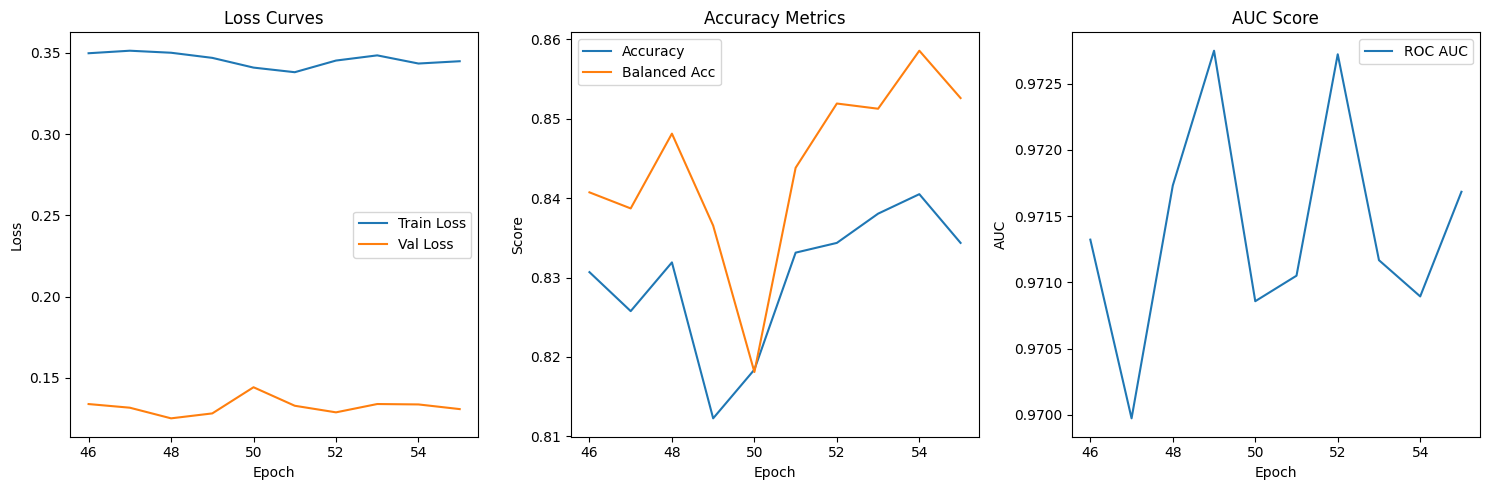

In [3]:
# Cell để tiếp tục training từ checkpoint với cấu hình hiện tại
def resume_training():
    import os
    
    # ===== 1. Thiết lập đường dẫn đến checkpoint =====
    CHECKPOINT_PATH = "/kaggle/input/tokenmixsmallval/pytorch/default/1/checkpoints/vit_meta_multiclass_tokenmix_epoch45.pth"  # Thay đổi đường dẫn này
    print(f"Tiếp tục training từ checkpoint: {CHECKPOINT_PATH}")
    
    # ===== 2. Đọc dữ liệu và chuẩn bị dataloader =====
    print("Đọc và chuẩn bị dữ liệu...")
    train_df = pd.read_csv(TRAIN_LABELS_PATH)
    val_df = pd.read_csv(VAL_LABELS_PATH)
    
    # Chuyển đổi sang dạng đa lớp
    train_df, label_map, class_names = convert_to_multiclass(train_df)
    val_df, _, _ = convert_to_multiclass(val_df)
    
    # Xử lý metadata
    metadata_df = pd.concat([
        pd.read_csv(TRAIN_METADATA_PATH),
        pd.read_csv(VAL_METADATA_PATH),
        pd.read_csv(TEST_METADATA_PATH)
    ])
    metadata_processed, meta_feature_cols = process_metadata(metadata_df)
    
    # Tạo datasets và dataloaders
    print("Tạo datasets và dataloaders...")
    train_dataset = DermDataset(
        img_dir=TRAIN_IMG_DIR,
        df=train_df,
        metadata_df=metadata_processed,
        meta_cols=meta_feature_cols,
        seg_dir=TRAIN_SEG_DIR,
        transform=get_train_transforms(True),
        use_seg=True,
        use_meta=True
    )
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=16,
        shuffle=True,  # Shuffle tiêu chuẩn
        num_workers=2,
        pin_memory=True
    )
    
    val_dataset = DermDataset(
        img_dir=VAL_IMG_DIR,
        df=val_df,
        metadata_df=metadata_processed,
        meta_cols=meta_feature_cols,
        seg_dir=VAL_SEG_DIR,
        transform=get_valid_transforms(True),
        use_seg=True,
        use_meta=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=32,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )
    
    # ===== 3. Tính class weights như cũ =====
    print("Tính toán class weights...")
    class_counts = train_df['diagnosis'].value_counts().sort_index()
    # Sử dụng effective numbers
    beta = 0.9999
    effective_num = 1.0 - np.power(beta, class_counts)
    weights = (1.0 - beta) / np.array(effective_num)
    weights = weights / np.sum(weights) * len(class_counts)
    class_weights = torch.FloatTensor(weights).to(device)
    
    # ===== 4. Khởi tạo model và load checkpoint =====
    # Xác định loại mô hình từ tên file
    is_swin = 'swin' in CHECKPOINT_PATH.lower()
    model_name = 'swin_base_patch4_window7_224' if is_swin else 'vit_base_patch16_224'
    patch_size = 4 if is_swin else 16
    print(f"Sử dụng model: {model_name} (patch_size={patch_size})")
    
    # Khởi tạo model
    model = DermModelWithMeta(
        model_name=model_name,
        num_classes=len(class_names),
        use_seg=True,
        use_meta=True,
        meta_dim=len(meta_feature_cols),
        pretrained=False
    )
    
    # Load checkpoint
    checkpoint = torch.load(CHECKPOINT_PATH)
    model.load_state_dict(checkpoint['model_state_dict'])
    start_epoch = checkpoint.get('epoch', 0) + 1
    print(f"Đã load checkpoint từ epoch {start_epoch-1}")
    
    model = model.to(device)
    
    # ===== 5. Khởi tạo criterion, optimizer và scheduler giống như cũ =====
    # Focal Loss với class weights
    criterion = MultiClassFocalLoss(alpha=class_weights, gamma=2)
    
    # Optimizer
    learning_rate = 3e-5  # Learning rate tiêu chuẩn
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    
    # Load optimizer state từ checkpoint nếu có
    if 'optimizer_state_dict' in checkpoint:
        try:
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            print("Đã khôi phục trạng thái optimizer")
        except:
            print("Không thể khôi phục trạng thái optimizer, khởi tạo mới")
    
    # Scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5
    )
    
    # Load scheduler state từ checkpoint nếu có
    if 'scheduler_state_dict' in checkpoint and checkpoint['scheduler_state_dict']:
        try:
            scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
            print("Đã khôi phục trạng thái scheduler")
        except:
            print("Không thể khôi phục trạng thái scheduler, khởi tạo mới")
    
    # ===== 6. Gọi hàm training với các tham số như cũ =====
    # Cấu hình đúng như tập tin tokenMixViT
    mixup_alpha = 0.4
    cutmix_alpha = 1.0
    mixup_prob = 0.1     # Xác suất MixUp giữ nguyên 10%
    cutmix_prob = 0.1    # Xác suất CutMix giữ nguyên 10%
    tokenmix_prob = 0.3  # Xác suất TokenMix giữ nguyên 30%
    num_epochs = 55      # Số epoch mặc định
    
    print(f"\nTiếp tục training với cấu hình ban đầu:")
    print(f"- Số epoch: {num_epochs - start_epoch + 1} (từ epoch {start_epoch} đến {num_epochs})")
    print(f"- Xác suất TokenMix: {tokenmix_prob}")
    print(f"- Xác suất MixUp: {mixup_prob}")
    print(f"- Xác suất CutMix: {cutmix_prob}")
    print(f"- Learning rate: {learning_rate}")
    
    # Gọi hàm train_and_evaluate_multiclass với tham số giống như cũ
    history = train_and_evaluate_multiclass(
        model,
        train_loader,
        val_loader,
        criterion,
        optimizer,
        scheduler,
        device,
        num_epochs=num_epochs,
        save_path='checkpoints',
        model_name='vit_meta_multiclass_tokenmix',
        save_interval=5,
        patience=20,
        mixup_alpha=mixup_alpha,
        cutmix_alpha=cutmix_alpha,
        mixup_prob=mixup_prob,
        cutmix_prob=cutmix_prob,
        tokenmix_prob=tokenmix_prob,
        start_epoch=start_epoch
    )
    
    # Lưu toàn bộ mô hình
    torch.save(model, 'checkpoints/full_model_vit_meta_tokenmix.pth')
    return history, model

# Chạy hàm để tiếp tục training
history, model = resume_training()